In [1]:
import json
import streamlit as st
import openai
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from typing import List, Annotated, Literal, Dict, Callable, TypeVar, Tuple, Type, Generic, Optional, Union, Any
from typing_extensions import TypedDict 

# LangChain 및 LangGraph 관련 라이브러리
from langchain.prompts import PromptTemplate
from langchain.prompts.chat import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.language_models.chat_models import BaseChatModel
from langchain.agents import AgentExecutor

from langgraph.types import Command
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import create_react_agent
from langsmith import utils 
from datetime import datetime, timedelta
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate


from sec_tool.insider_trade_tool import SECInsiderTradeAPI
from sec_tool.market_data_tool import MarketDataTools, FinancialDataTools, EconomicDataTools

from agents.agent_library import agent_configs
from team_graph.report_team_subgraph import report_graph
from team_graph.general_chat_subgraph import general_graph

# 환경 변수 로드
load_dotenv()
print(utils.tracing_is_enabled())

In [3]:
class AgentState(MessagesState):
    query: str


In [4]:
llm = ChatOpenAI(model="gpt-4o-mini-2024-07-18")

In [ ]:
# 시장 조사 에이전트
news_and_sentiment_retrieval_tools = [MarketDataTools.get_stock_news, MarketDataTools.get_websearch_tool()] # 여기 ㄷ통일
news_and_sentiment_retrieval_agent = create_react_agent(
    llm, 
    tools=news_and_sentiment_retrieval_tools,
    prompt=agent_configs['news_and_sentiment_retrieval_agent']['prompt']
)

market_data_tools = [MarketDataTools.get_stock_price]
market_data_retrieval_agent = create_react_agent(
    llm, tools=market_data_tools, 
    prompt = agent_configs['market_data_retrieval_agent']['prompt']
)


economic_data_retrieval_tools = [EconomicDataTools.get_core_cpi_data]
economic_data_retrieval_agent = create_react_agent(
    llm, tools=economic_data_retrieval_tools, 
    prompt=agent_configs['economic_data_retrieval_agent']['prompt']
)


financial_statement_retrieval_tools = [FinancialDataTools.get_income_statement, FinancialDataTools.get_financial_event_filings]
financial_statement_retrieval_agent = create_react_agent(
    llm,
    tools=financial_statement_retrieval_tools,
    prompt = agent_configs['financial_statement_retrieval_agent']['prompt']
)

insider_tracker_research_tools = [SECInsiderTradeAPI.fetch_filings]
insider_tracker_research_agent = create_react_agent(
    llm, tools=insider_tracker_research_tools, 
    prompt=agent_configs['insider_tracker_research_agent']['prompt']
)




In [5]:
def news_and_sentiment_retrieval_node(state: AgentState) -> Command[Literal["data_retrieval_leader"]]:
    """
    금융 뉴스 및 애널리스트 의견 수집

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        Command: supervisor node로 이동하기 위한 명령을 반환
    """
    # 시장 조사 에이전트를 호출하여 결과를 얻습니다.
    result = news_and_sentiment_retrieval_agent.invoke(state)
    
    # 결과 메시지를 업데이트하고 supervisor node로 이동합니다.
    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='news_and_sentiment_retrieval')]},
        goto='data_retrieval_leader'
    )



In [6]:
def market_data_retrieval_node(state: AgentState) -> Command[Literal["data_retrieval_leader"]]:
    """
    실시간 주가 및 거래량 수집
    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        Command: supervisor node로 이동하기 위한 명령을 반환
    """
    result = market_data_retrieval_agent.invoke(state)

    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='market_data_retrieval')]},
        goto='data_retrieval_leader'
    )

In [7]:
def economic_data_retrieval_node(state: AgentState) -> Command[Literal["data_retrieval_leader"]]:
    """
    거시경제 데이터(GDP, 금리, 인플레이션) 수집
    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        Command: supervisor node로 이동하기 위한 명령을 반환
    """
    result = economic_data_retrieval_agent.invoke(state)

    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='economic_data_retrieval')]},
        goto='data_retrieval_leader'
    )

In [8]:
def financial_statement_retrieval_node(state: AgentState) -> Command[Literal["data_retrieval_leader"]]:
    """
    회사 재무 보고서와 주요 사건 관련 자료를 조사하는 노드.
    손익계산서 데이터와 재무 및 주요 사건 관련 SEC 보고서를 처리합니다.

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        Command: supervisor 노드로 이동하기 위한 명령을 반환
    """
    result = financial_statement_retrieval_agent.invoke(state)
    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='financial_statement_retrieval')]},
        goto='data_retrieval_leader'
    )


In [9]:
def insider_tracker_research_node(state: AgentState) -> Command[Literal["data_retrieval_leader"]]:
    """
    내부자 거래 내역 조사 node 
    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        Command: supervisor node로 이동하기 위한 명령을 반환
    """
    result = insider_tracker_research_agent.invoke(state)

    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='insider_tracker_research')]},
        goto='data_retrieval_leader'
    )

In [10]:
data_retrieval_team_members = [
    "news_and_sentiment_retrieval", "market_data_retrieval", 
    "financial_statement_retrieval","insider_tracker_research",
    "economic_data_retrieval"
    ]
data_retrieval_options_for_next = data_retrieval_team_members + ["FINISH"]
data_retrieval_leader_system_prompt = agent_configs['data_retrieval_leader_agent']['prompt']


# ChatPromptTemplate 생성
data_retrieval_leader_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", data_retrieval_leader_system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next? "
            "Or should we FINISH? Select one of: {options}. "
            "Return a JSON with 'next', 'is_vague', and optionally 'response' if vague. "
            "If not vague and no clarification is needed, leave 'response' empty."
        ),
    ]
).partial(options=str(data_retrieval_options_for_next), members=", ".join(data_retrieval_team_members))

class DataTeamRouter(TypedDict):
    """Worker to route to next. If no workers needed or question is vague, route to FINISH."""
    next: Literal[*data_retrieval_options_for_next]
    is_vague: bool  # 질문이 모호한지 여부
    response: Optional[str]

def data_retrieval_leader_node(state: AgentState) -> Command[Literal[*data_retrieval_team_members, "data_cleansing"]]:
    """
    supervisor node 
    주어진 State를 기반으로 각 worker의 결과를 종합하고,
    다음에 수행할 worker를 결정
    모든 작업이 완료되면 data_cleansing node로 이동

    Args:
        state (AgentState): 현재 메시지 상태를 나타내는 객체

    Returns:
        Command: 다음에 수행할 worker 또는 data_cleansing node로 이동하기 위한 명령 반환 
    """

    data_retrieval_team_chain = data_retrieval_leader_prompt | llm.with_structured_output(DataTeamRouter)
    response= data_retrieval_team_chain.invoke(state)


    goto = response["next"]
    if response["is_vague"]:
        # 모호한 경우 reporter로 이동, response가 있으면 메시지 추가
        return Command(
            update={'messages': [HumanMessage(content=response["response"], name='data_retrieval_leader')] if response["response"] else None},
            goto='reporter'
        )
    elif goto == "FINISH":
        goto = "data_cleansing"  # 정상 종료 시

    return Command(goto=goto)


In [11]:
data_cleansing_system_prompt = agent_configs['data_cleansing_agent']['prompt']

# ChatPromptTemplate 생성
data_cleansing_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", data_cleansing_system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, "
            "Refine and process this data to align with the user's original question : {query}"
        )
    ]
)


def data_cleansing_node(state: AgentState) -> Command[Literal["supervisor"]]:
    """
    데이터 클렌징 노드. 수집된 데이터를 정제하여 supervisor로 전달

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        dict: 분석 결과 메시지를 포함하는 딕셔너리를 반환
    """

    class CleanedData(BaseModel):
        relevant_data: str = Field(
            ..., description="사용자의 질문과 직접 연관이 있고, 중복 및 불필요한 정보가 제거된 정제된 데이터"
        )

    query = state['query']
    cleaning_chain = data_cleansing_prompt | llm.with_structured_output(CleanedData)
    result = cleaning_chain.invoke({"messages" : state['messages'], "query" : query})

    return Command(
        update={'messages': [HumanMessage(content=result.relevant_data, name='data_cleansing')]},
        goto='supervisor'
    )

In [12]:
supervisor_members = ["data_retrieval_leader", "general_team_leader"]
supervisor_options_for_next = supervisor_members + ["FINISH"]

supervisor_system_prompt = agent_configs['supervisor']['prompt']


# ChatPromptTemplate 생성
supervisor_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", supervisor_system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next? "
            "Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(supervisor_options_for_next), members=", ".join(supervisor_members))


class Router(TypedDict):
    next: Literal[*supervisor_options_for_next]
    

def supervisor_node(state: AgentState) -> Command[Literal[*supervisor_members, "reporter"]]:
    """
    supervisor node 
    주어진 State를 기반으로 각 worker의 결과를 종합하고,
    다음에 수행할 worker를 결정
    모든 작업이 완료되면 analyst node로 이동

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        Command: 다음에 수행할 worker 또는 analyst node로 이동하기 위한 명령 반환 
    """

    supervisor_chain = supervisor_prompt | llm.with_structured_output(Router)
    response= supervisor_chain.invoke(state)

    goto = response["next"]
    if goto == "FINISH":
        goto = "reporter"

    return Command(goto=goto)

In [13]:
graph_builder = StateGraph(AgentState)

graph_builder.add_node("supervisor", supervisor_node)
graph_builder.add_node("news_and_sentiment_retrieval", news_and_sentiment_retrieval_node)
graph_builder.add_node("market_data_retrieval", market_data_retrieval_node)
graph_builder.add_node("financial_statement_retrieval", financial_statement_retrieval_node)
graph_builder.add_node("insider_tracker_research", insider_tracker_research_node)
graph_builder.add_node("data_retrieval_leader", data_retrieval_leader_node)
graph_builder.add_node("data_cleansing", data_cleansing_node)
graph_builder.add_node("economic_data_retrieval", economic_data_retrieval_node)
graph_builder.add_node("reporter", report_graph)
graph_builder.add_node("general_team_leader", general_graph)

graph_builder.add_edge(START, "supervisor")
graph_builder.add_edge("reporter", END)
graph_builder.add_edge("general_team_leader", END)

graph = graph_builder.compile()



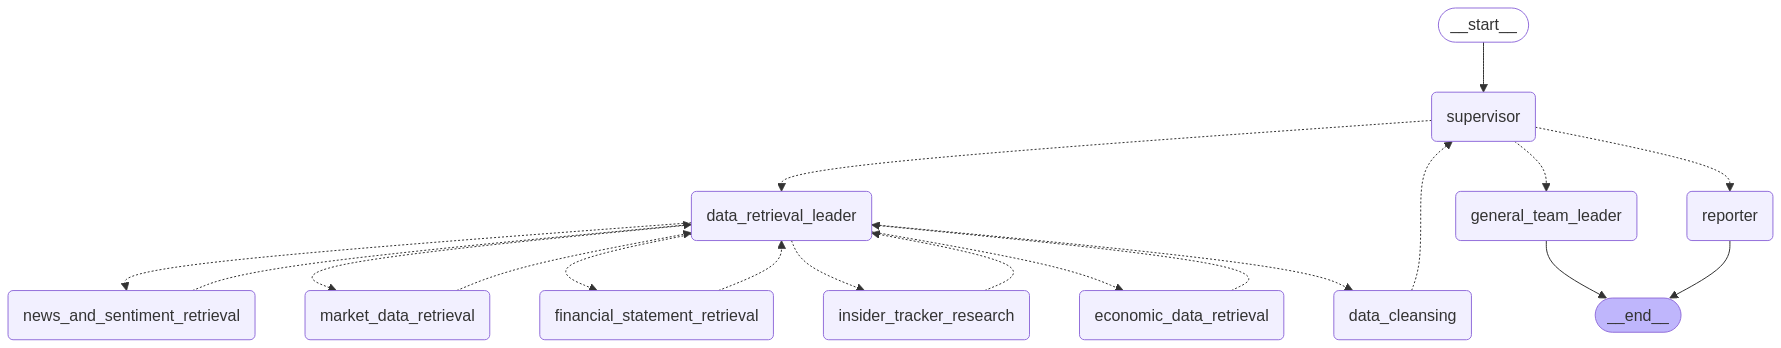

In [14]:
graph

In [15]:
query =  "김치찌개 만드는법"
for chunk in graph.stream(
    {"messages": [("user",query)], "query" :query}, stream_mode="values"
):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

김치찌개 만드는법
================================ Human Message =================================

김치찌개는 한국의 대표적인 찌개로, 다음과 같은 방법으로 만들 수 있습니다.

### 재료
- 김치 2컵 (숙성된 김치)
- 돼지고기 150g (삼겹살 또는 목살)
- 두부 1/2모
- 양파 1개
- 대파 1대
- 마늘 2-3쪽
- 고춧가루 1-2큰술
- 국간장 또는 소금 (간 맞추기용)
- 물 3컵

### 만드는 법
1. **재료 준비**: 김치는 적당한 크기로 자르고, 돼지고기는 한입 크기로 썬다. 양파와 대파도 썰고, 마늘은 다진다. 두부는 큐브 모양으로 자른다.
2. **고기 볶기**: 냄비에 돼지고기를 넣고 중불에서 볶아 기름이 나오게 한다.
3. **김치 넣기**: 돼지고기가 익으면 김치를 넣고 볶아준다. 김치가 익으면서 국물이 나올 때까지 계속 볶는다.
4. **물 붓기**: 물 3컵을 부은 후, 고춧가루와 다진 마늘을 넣고 끓인다.
5. **재료 추가**: 끓기 시작하면 양파와 두부를 넣고, 중불로 15-20분 정도 끓인다.
6. **마무리**: 대파를 넣고, 국간장 또는 소금으로 간을 맞춘 후, 한 번 더 끓여서 완성한다.

### 팁
- 김치의 숙성 정도에 따라 맛이 달라질 수 있으니, 개인의 취향에 맞게 조절하세요.
- 더 매운 맛을 원하면 고춧가루를 추가하거나 청양고추를 넣어도 좋습니다.

금융 외 질문에 대한 답변은 정확도가 떨어질 수 있다는 점을 인지해주세요.


In [24]:
query =  "최근 내부자가 가장 많은 지분을 매수한 상장사는 어디야"
for chunk in graph.stream(
    {"messages": [("user",query)], "query" :query}, stream_mode="values"
):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

최근 내부자가 가장 많은 지분을 매수한 상장사는 어디야
200
================================ Human Message =================================
Name: insider_tracker_research

가장 최근에 내부자가 가장 많은 지분을 매수한 상장사는 다음과 같습니다:

1. **RENN Fund, Inc. (RCG)**
   - 내부자: **Murray Stahl** (회장 겸 CEO)
   - 매수 날짜: 2025-03-25
   - 매수한 주식 수: 1,084주 (여러 거래 포함)
   - 평균 가격: $2.61
   - 매수 후 소유 주식: 총 276,740주

2. **Community West Bancshares (CWBC)**
   - 내부자: **Dorothea D. Silva** (이사)
   - 매수 날짜: 2025-03-19
   - 매수한 주식 수: 56.7443주
   - 매수 가격: $18.26
   - 매수 후 소유 주식: 총 10,224.7443주

이 데이터는 최근 내부자 거래를 기준으로 하며, RCG에서 가장 많은 주식을 매수한 것으로 확인됩니다.
================================ Human Message =================================
Name: data_cleansing

가장 최근에 내부자가 가장 많은 지분을 매수한 상장사는 **RENN Fund, Inc. (RCG)**입니다. 내부자 **Murray Stahl**이 2025-03-25에 1,084주를 평균 $2.61에 매수했습니다.
================================== Ai Message ==================================

가장 최근에 내부자가 가장 많은 

In [26]:
query =  "하이"
for chunk in graph.stream(
    {"messages": [("human",query)], "query" :query}, stream_mode="values"
):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

하이
{'messages': [HumanMessage(content='하이', additional_kwargs={}, response_metadata={}, id='3a1590bc-d1c7-483c-a836-a0d1209a8978')], 'query': '하이'}
================================ Human Message =================================

안녕하세요! 무엇을 도와드릴까요? 궁금한 점이 있다면 말씀해 주세요. 

금융 외 질문에 대한 답변은 정확도가 떨어질 수 있다는 점을 인지해주세요.


In [17]:
query =  "너는 미국주식에 특화되어있냐"
for chunk in graph.stream(
    {"messages": [("user",query)], "query" :query}, stream_mode="values"
):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

너는 미국주식에 특화되어있냐
================================ Human Message =================================

네, finbrain은 미국 주식에 특화되어 있으며, 주가 정보, SEC Filing 데이터, 뉴스 및 경제 지표를 활용해 투자 결정을 지원합니다.


In [18]:
query =  "무슨 질문에 대답할수있냐"
for chunk in graph.stream(
    {"messages": [("user",query)], "query" :query}, stream_mode="values"
):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

무슨 질문에 대답할수있냐
================================ Human Message =================================

저는 미국 주식에 관한 다양한 질문에 답할 수 있습니다. 예를 들어, 특정 주식의 성과, SEC Filing 데이터, 경제 지표, 최근 뉴스 등과 관련된 정보를 제공하며, 투자 결정을 도울 수 있습니다.


In [19]:
query =  "너는 바보냐"
for chunk in graph.stream(
    {"messages": [("user",query)], "query" :query}, stream_mode="values"
):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

너는 바보냐
{'messages': [HumanMessage(content='너는 바보냐', additional_kwargs={}, response_metadata={}, id='fc239924-39ce-48c0-96f4-9ddd12de8485')], 'query': '너는 바보냐'}
================================ Human Message =================================

저는 바보가 아닙니다. 질문이나 도움이 필요한 부분이 있다면 말씀해 주세요. 최선을 다해 도와드리겠습니다. 금융 외 질문에 대한 답변은 정확도가 떨어질 수 있다는 점을 인지해주세요.


In [16]:
for chunk in graph.stream(
    {"messages": [("user", "최근 한달간 테슬라 내부자 거래가 있었는지 확인해줘")]}, stream_mode="values"
):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

최근 한달간 테슬라 내부자 거래가 있었는지 확인해줘



KeyboardInterrupt



In [16]:
query= "오늘 테슬라 주가가 얼마냐"
for chunk in graph.stream(
    {"messages": [("user", query)], "query" : query}, stream_mode="values"
    ):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

오늘 테슬라 주가가 얼마냐
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


================================ Human Message =================================
Name: market_data_retrieval

오늘 테슬라(TSLA)의 주가는 다음과 같습니다:

- 종가: $275.53
- 최고가: $276.10
- 최저가: $268.84
- 시가: $275.50
- 거래량: 18,126,775 주
================================ Human Message =================================
Name: data_cleansing

오늘 테슬라(TSLA) 주가는 $275.53입니다.
================================== Ai Message ==================================

오늘 테슬라(TSLA)의 주가는 $275.53입니다.


In [20]:
query = "최근 테슬라 주가 흐름과 테슬라 주가에 영향을 주고있는 이슈를 찾아봐"
for chunk in graph.stream(
    {"messages": [("user", query)], "query" : query}, stream_mode="values"
    ):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

최근 테슬라 주가 흐름과 테슬라 주가에 영향을 주고있는 이슈를 찾아봐
================================ Human Message =================================
Name: news_and_sentiment_retrieval

### Recent Tesla Stock News

1. **Elon Musk is creating a PR headache for Tesla**
   - **Summary**: Elon Musk's involvement with DOGE and the Trump administration has led to backlash against Tesla.
   - **Published**: March 26, 2025
   - **URL**: [Read more](https://finance.yahoo.com/video/elon-musk-creating-pr-headache-142707481.html)

2. **Car critic explains why he bought a Tesla**
   - **Summary**: Despite backlash due to Musk's political involvement, a Wall Street Journal auto columnist shares his positive experience with a used Tesla Model 3.
   - **Published**: March 25, 2025
   - **URL**: [Read more](https://finance.yahoo.com/video/car-critic-explains-why-bought-213201994.html)

3. **Tesla's US dominance at risk amid global competition**
   - *